# Dense Vector Search


***

In this notebook, you will learn how to use language models for constructing a simple search engine. You will use three different approaches for obtaining document embeddings: Doc2Vec, TF-IDF and Sentence-Transformer. Afterwards, we will experiment with index structures to reduce query times. Finally, you will compare the three approaches for retrieving relevant news articles given a short search query.


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from IPython.display import display
from time import time, process_time
from nltk.corpus import stopwords
from gensim import utils
from tqdm import tqdm
import gensim.downloader as api
import gensim.models
import pandas as pd
import numpy as np
import json
import nltk
import time
from gensim.models.doc2vec import Doc2Vec

nltk.download('stopwords')
stop = set(stopwords.words('english'))
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Vector Search

In this task, you will train both a Doc2Vec and TF-IDF model and use them to build a simple search engine.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load and Process the Dataset</b> 
</div>

First, you need to add [this](https://www.kaggle.com/datasets/julianschelb/newsdata) dataset containing news articles to your notebook. Click on "+Add data" and the dataset. In the first task, you will load and filter the data. Please implement the following steps:

1. Load the dataset by reading the CSV file _relevant_articles.json_.
2. Sample a training set consisting of 30,000 examples and a test set of 500 examples.

In [2]:
# Read article data
with open("/kaggle/input/relevants/relevant_articles.json","rb") as d:
    relevant_articles = json.load(d)

In [3]:
# Preprocess data
articles = pd.json_normalize(relevant_articles)
# Convert to DataFrame

In [4]:
# Sample training and test examples
training_sample = articles.iloc[:30000]
test_sample = articles.iloc[30000:30500]

# Remove linebreaks
training_sample["text"] = training_sample["text"].replace('\n', '')
test_sample["text"] = test_sample["text"].replace('\n', '')
training_sample["text"] = training_sample["text"].replace('\n', '')
test_sample["text"] = test_sample["text"].str.lower()

/tmp/ipykernel_26/820678523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_sample["text"] = training_sample["text"].replace('\n', '')
/tmp/ipykernel_26/820678523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["text"] = test_sample["text"].replace('\n', '')
/tmp/ipykernel_26/820678523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Train Doc2Vec Model</b> 
</div>

Building on the code from previous assignments and using the news dataset you are already familiar with, train a Doc2Vec model on the text of all news articles in your training set. We will use this model later to obtain document embeddings. Please implement the following steps:
1. Preprocess the articles content (i.e. column "text") using the [gensim.models.doc2vec.TaggedDocument()](https://radimrehurek.com/gensim/models/doc2vec.html?highlight=taggeddocument#gensim.models.doc2vec.TaggedDocument) function yielding a tokenized article and its index.
2. [Train a Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html) model with the preprocessed articles. Specify a vector size of 768 before training. With epochs = 10, this should take you ~6 min.

In [5]:
# This function will be used later in task 2.

def trainDoc2VecVariations(size):
    training_sample_doc2vec = articles.iloc[:size]
    train_corpus = list(read_corpus(training_sample_doc2vec["text"]))
    model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=768, min_count=2, epochs=10)
    model_doc2vec.build_vocab(train_corpus)
    model_doc2vec.train(train_corpus, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)
    model_doc2vec.save(f"doc2vec_model.a5.{size}")

In [6]:
# Preprocess training data (articles)
def read_corpus(articles, tokens_only=False):
    for i, article in enumerate(articles):
        tokens = gensim.utils.simple_preprocess(article)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [7]:
train_corpus = list(read_corpus(training_sample["text"]))

In [8]:
# Train Doc2Vec model with default parameters (epochs=10)

# Preprocess Data
# The read_corpus function already did the preprocessing.

# Define model
model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=768, min_count=2, epochs=10)

# Build model vocabulary
model_doc2vec.build_vocab(train_corpus)

# Train model
model_doc2vec.train(train_corpus, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)

# Optionally save model
model_doc2vec.save("doc2vec_model.a5")

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Implement Vector Search (Doc2Vec)</b> 
</div>

Now we want to use the model to search for similar news articles. 

1. Write a function **searchWithEmbedding(embeddings, model, query, N, stopwordflag)** with 4 parameters that takes a sentence "query" as input and returns the "N" most related news articles. "stopwordflag" should be a Boolean flag that can be used to toggle the removal of stopwords from the query sentence. Internally, the function should use the pretrained Doc2Vec model to embed the query sentence and find the N most similar document embeddings by cosine distance, then retrieve the corresponding news articles. 

To test your function, implement the following steps: 

2. Use the doc2vec model to embed all the articles in the test set.
3. Use an entire article from the test set as query. Your function should be able to identify this article as a perfect match.

*(Hint: You may find [.infer_vector()](https://radimrehurek.com/gensim/models/doc2vec.html?highlight=taggeddocument#gensim.models.doc2vec.Doc2Vec.infer_vector), [KeyedVectors()](https://radimrehurek.com/gensim/models/keyedvectors.html) and [.similar_by_vector()](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.similar_by_vector) helpful for this task.)*

In [9]:
# Optionally load model 
#model = gensim.models.doc2vec.Doc2Vec.load("doc2vec_model.h5")

In [10]:
# Encode sentences in test dataset using doc2vec
test_sample["embeddings"] = test_sample["text"].apply(lambda x: model_doc2vec.infer_vector(word_tokenize(x)))

/tmp/ipykernel_26/4261520595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["embeddings"] = test_sample["text"].apply(lambda x: model_doc2vec.infer_vector(word_tokenize(x)))


In [11]:
test_sample.head()

_id                                                url  \
30000  516605  http://www.huffingtonpost.com/2016/07/14/wide-...   
30001  516612  http://www.cbsnews.com/videos/how-governor-mik...   
30002  516618  http://hosted.ap.org/dynamic/stories/U/US_GOP_...   
30003  516619  http://www.huffingtonpost.com/2016/07/15/chris...   
30004  516632  http://hosted.ap.org/dynamic/stories/U/US_GOP_...   

                                                   title          feed  \
30000  How Women Raped In Prison Are Left Voiceless A...  HuffingtonUS   
30001  How Gov. Mike Pence as VP pick could help Dona...           CBS   
30002       Ohio delegation gives cold shoulder to Trump            AP   
30003  Chris Colfer Praises Clinton, Blasts Trump As ...  HuffingtonUS   
30004  Trump, Pence don't agree on key social, econom...            AP   

           type lang                                               refs  \
30000  politics   en  [https://www.washingtonpost.com/news/acts-of-f...   
30001  politics   en                                                NaN   
30002  politics   en                                                NaN   
30003  politics   en  [http://metro.co.uk/2016/07/14/the-next-harry-...   
30004  politics   en                                                NaN   

                                                     sum  \
30000  A prison chaplain who admitted to sexually ass...   
30001                                                NaN   
30002                                                NaN   
30003  "I think she’s quite extraordinary,” the "Glee...   
30004                                                NaN   

                                                    body  \
30000  When Leticia Villarreal, 42, began her prison ...   
30001                                                NaN   
30002                                                NaN   
30003  “Glee” star Chris Colfer is reveling in his ro...   
30004                                                NaN   

                                                    text  \
30000  a prison chaplain who admitted to sexually ass...   
30001  philip bump, politics reporter for "the washin...   
30002  cincinnati (ap) -- ohio republicans starting w...   
30003  "i think she’s quite extraordinary,” the "glee...   
30004  washington (ap) -- when gop presumptive presid...   

                          pub.$date                     ret.$date  \
30000  2016-07-16T12:05:23.000+0000  2016-07-16T12:15:05.000+0000   
30001  2016-07-16T16:17:30.000+0000  2016-07-16T12:25:24.000+0000   
30002  2016-07-16T12:29:17.000+0000  2016-07-16T12:29:17.000+0000   
30003  2016-07-16T12:25:33.000+0000  2016-07-16T12:35:05.000+0000   
30004  2016-07-16T12:49:13.000+0000  2016-07-16T12:49:13.000+0000   

                            auth  \
30000                        NaN   
30001                        NaN   
30002                 DAN SEWELL   
30003                        NaN   
30004  JEFF HORWITZ and CHAD DAY   

                                              embeddings  
30000  [0.3006543, 0.41794938, 0.11917406, 0.44846717...  
30001  [-0.24777256, 0.2763031, 0.009903646, -0.02256...  
30002  [-0.08889585, 0.118441306, 0.05605289, -0.3768...  
30003  [0.10347333, 0.49223968, 0.21085554, -0.609640...  
30004  [-0.21718864, 0.0010540042, 0.047764894, -0.26...

In [12]:
def preprocess_query(query, remove_stopwords):
    if remove_stopwords:
        query = ' '.join([word for word in query.split() if word.lower() not in stop])
    return query

def searchWithEmbedding(embeddings, model, query, N, stopwordflag, q_index):
    global index_d2v
    # Preprocess query
    query = preprocess_query(query, stopwordflag)

    # Infer vector for the query using the trained model
    query_vector = model.infer_vector(query.split())

    embeddings = np.array([vec.tolist() for vec in embeddings])
    # Calculate cosine similarity between the query vector and all document vectors
    similarities = cosine_similarity(np.array(embeddings), query_vector.reshape(1, -1))

    # Get the indices of the top N most similar documents
    top_indices = np.argsort(similarities[:, 0])[::-1][:N]
    index_d2v = np.argmax(top_indices == q_index)

    # Retrieve the corresponding news articles
    top_articles = [test_sample.iloc[i]["text"] for i in top_indices]

    return top_articles

In [13]:
# Test your search implementation

# Define query
query_article_index = 0  # Replace with the index of the article you want to use as a query
query_article = test_sample.iloc[query_article_index]["text"]
N = 5  # Number of most related news articles to retrieve
stopwordflag = True  # Toggle stopword removal

# Call the searchWithEmbedding function
result_articles = searchWithEmbedding(test_sample['embeddings'], model_doc2vec, query_article, N, stopwordflag, query_article_index)

# Print the results
print(f"Query Article:\n{query_article}\n")
print(f"Top {N} Most Related Articles:")
for i, article in enumerate(result_articles, start=1):
    print(f"{i}. {article}\n")


Query Article:
a prison chaplain who admitted to sexually assaulting three inmates may only spend a year behind bars. why don't we seem to care?

 

when leticia villarreal, 42, began her prison sentence at mcpherson unit, a women’s facility in arkansas, she throbbed with anger and pain. she was an undocumented immigrant from mexico. she didn’t speak english. no one visited, no one called. she deeply missed her children. she was, for the first time in her life, utterly alone.
and then, she found god.
kenneth dewitt, a charismatic prison chaplain, welcomed her into the principles and applications for life, or pal, program ― a religious initiative for inmates that’s based on the teachings of disgraced evangelical fundamentalist bill gothard.
women in the pal program lived in a separate barracks and dedicated much of their days to study and prayer. it was quieter and cleaner than living with the general population, villarreal said, an overall improvement in quality of life. and it was rum

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Implement Vector Search (TF-IDF)</b> 
</div>

For comparison, we will also train a TF-IDF model to encode documents. Recall your background knowledge of the vector space model and [TF-IDF](http://www.tfidf.com). 
Create a TF-IDF-weighted term-document matrix from the news articles. You may use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) method from sklearn. 
For simplicity, use stemming to create word stems (instead of 
lemmatization). Use the [SnowballStemmer](https://www.nltk.org/api/nltk.stem.snowball.html) from nltk. This should take you ~5 min.

1. Write a function **searchWithTFIDF(embeddings, vectorizer, query, N, stopwordflag)** with similar functionality to the search function you implemented as part of Step 3. Internally, the function should convert the query string to a TF-IDF-vector and use cosine similarity to find the N most similar documents. 

2. Use the TF-IDF-vectorizer to embed all the articles in the test set. Finally, test your implementation as you did for Step 3.

*(Hint: You can find the N highest values in a list using this code snippet: "(-list).argsort()[:N])"*

In [14]:
# Define stemmer
stemmer = SnowballStemmer("english")
def preprocess_and_stem(text, remove_stopwords=True):
    words = word_tokenize(text)
    if remove_stopwords:
        words = [word for word in words if word.lower() not in stop]
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Stem words in all articles
test_sample['preprocessed_text'] = test_sample['text'].apply(preprocess_and_stem)
test_sample.head()

/tmp/ipykernel_26/2709917903.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['preprocessed_text'] = test_sample['text'].apply(preprocess_and_stem)


_id                                                url  \
30000  516605  http://www.huffingtonpost.com/2016/07/14/wide-...   
30001  516612  http://www.cbsnews.com/videos/how-governor-mik...   
30002  516618  http://hosted.ap.org/dynamic/stories/U/US_GOP_...   
30003  516619  http://www.huffingtonpost.com/2016/07/15/chris...   
30004  516632  http://hosted.ap.org/dynamic/stories/U/US_GOP_...   

                                                   title          feed  \
30000  How Women Raped In Prison Are Left Voiceless A...  HuffingtonUS   
30001  How Gov. Mike Pence as VP pick could help Dona...           CBS   
30002       Ohio delegation gives cold shoulder to Trump            AP   
30003  Chris Colfer Praises Clinton, Blasts Trump As ...  HuffingtonUS   
30004  Trump, Pence don't agree on key social, econom...            AP   

           type lang                                               refs  \
30000  politics   en  [https://www.washingtonpost.com/news/acts-of-f...   
30001  politics   en                                                NaN   
30002  politics   en                                                NaN   
30003  politics   en  [http://metro.co.uk/2016/07/14/the-next-harry-...   
30004  politics   en                                                NaN   

                                                     sum  \
30000  A prison chaplain who admitted to sexually ass...   
30001                                                NaN   
30002                                                NaN   
30003  "I think she’s quite extraordinary,” the "Glee...   
30004                                                NaN   

                                                    body  \
30000  When Leticia Villarreal, 42, began her prison ...   
30001                                                NaN   
30002                                                NaN   
30003  “Glee” star Chris Colfer is reveling in his ro...   
30004                                                NaN   

                                                    text  \
30000  a prison chaplain who admitted to sexually ass...   
30001  philip bump, politics reporter for "the washin...   
30002  cincinnati (ap) -- ohio republicans starting w...   
30003  "i think she’s quite extraordinary,” the "glee...   
30004  washington (ap) -- when gop presumptive presid...   

                          pub.$date                     ret.$date  \
30000  2016-07-16T12:05:23.000+0000  2016-07-16T12:15:05.000+0000   
30001  2016-07-16T16:17:30.000+0000  2016-07-16T12:25:24.000+0000   
30002  2016-07-16T12:29:17.000+0000  2016-07-16T12:29:17.000+0000   
30003  2016-07-16T12:25:33.000+0000  2016-07-16T12:35:05.000+0000   
30004  2016-07-16T12:49:13.000+0000  2016-07-16T12:49:13.000+0000   

                            auth  \
30000                        NaN   
30001                        NaN   
30002                 DAN SEWELL   
30003                        NaN   
30004  JEFF HORWITZ and CHAD DAY   

                                              embeddings  \
30000  [0.3006543, 0.41794938, 0.11917406, 0.44846717...   
30001  [-0.24777256, 0.2763031, 0.009903646, -0.02256...   
30002  [-0.08889585, 0.118441306, 0.05605289, -0.3768...   
30003  [0.10347333, 0.49223968, 0.21085554, -0.609640...   
30004  [-0.21718864, 0.0010540042, 0.047764894, -0.26...   

                                       preprocessed_text  
30000  prison chaplain admit sexual assault three inm...  
30001  philip bump , polit report `` washington post ...  
30002  cincinnati ( ap ) -- ohio republican start gov...  
30003  `` think ’ quit extraordinari , ” `` glee '' s...  
30004  washington ( ap ) -- gop presumpt presidenti n...

In [15]:
# Create tfidf model + fit/transform article data
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(test_sample['preprocessed_text'])

In [16]:
# Encode sentences in test dataset using TF-IDF
def encode_sentences_with_tfidf(vectorizer, sentences):
    # Preprocess and stem the sentences
    preprocessed_sentences = [preprocess_and_stem(sentence) for sentence in sentences]

    # Transform the preprocessed sentences using TF-IDF vectorizer
    sentence_vectors = vectorizer.transform(preprocessed_sentences)

    return sentence_vectors

In [17]:
def searchWithTFIDF(embeddings, vectorizer, query, N, stopwordflag, q_index):
    # Encode the query using TF-IDF
    global index_tfi
    query_vector = encode_sentences_with_tfidf(vectorizer, [query])

    # Calculate cosine similarity between the query vector and all document vectors
    similarities = cosine_similarity(embeddings, query_vector)

    # Get the indices of the top N most similar documents
    top_indices = (-similarities).argsort(axis=None)[:N]
    index_tfi = np.argmax(top_indices == q_index)
    # Retrieve the corresponding news articles
    top_articles = [test_sample.iloc[i]['text'] for i in top_indices]

    return top_articles

In [18]:
# Test your search implementation
# Define query
query_article_index = 0  # Replace with the index of the article you want to use as a query
query_article = test_sample.iloc[query_article_index]['text']
N = 5  # Number of most related news articles to retrieve
stopwordflag = True  # Toggle stopword removal

# Call the searchWithTFIDF function
result_articles_tfidf = searchWithTFIDF(tfidf_matrix, vectorizer, query_article, N, stopwordflag,query_article_index)

# Print the results
print(f"Query Article:\n{query_article}\n")
print(f"Top {N} Most Related Articles using TF-IDF:")
for i, article in enumerate(result_articles_tfidf, start=1):
    print(f"{i}. {article}\n")

Query Article:
a prison chaplain who admitted to sexually assaulting three inmates may only spend a year behind bars. why don't we seem to care?

 

when leticia villarreal, 42, began her prison sentence at mcpherson unit, a women’s facility in arkansas, she throbbed with anger and pain. she was an undocumented immigrant from mexico. she didn’t speak english. no one visited, no one called. she deeply missed her children. she was, for the first time in her life, utterly alone.
and then, she found god.
kenneth dewitt, a charismatic prison chaplain, welcomed her into the principles and applications for life, or pal, program ― a religious initiative for inmates that’s based on the teachings of disgraced evangelical fundamentalist bill gothard.
women in the pal program lived in a separate barracks and dedicated much of their days to study and prayer. it was quieter and cleaner than living with the general population, villarreal said, an overall improvement in quality of life. and it was rum

## Task 2: Approximate Nearest Neighbors Search

In previous tasks, we utilized Doc2Vec and TF-IDF to encode documents as points in vector space. To search for similar documents (i.e. articles), we needed to  compare the query with **every** document in the corpus, using cosine similarity as metric. This can result in long query times if we work with larger document collections.

To reduce query times, libraries like [Annoy](https://github.com/spotify/annoy) create indices by organizing the document embeddings in a tree like structure. At every node in the tree, the vector space is divided into two subspaces. This reduces the search space for nearest neighbor searches. Consequently, the number of comparisons is reduced because it is no longer necessary to compare the query with all documents in the corpus. Retrieving similar documents can therefore be done much faster.

svg image


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Compare Query Runtimes</b> 
</div>

In theory, indexing the articles should reduce query times. To validate that claim, we will compare the query time using Annoy against Doc2Vec for different corpus sizes. Please implement the following steps:

1. Create Annoy indices holding *10000, 15000, 20000, 25000 and 30000* documents using the article IDs as key and the Doc2Vec embeddings as values. You can read [here](https://github.com/spotify/annoy) about how to create indices with Annoy.
2. Measure the average query time for 1000 queries using Gensims *.most_similar()* method and Annoy's *.get_nns_by_vector()* method. Select the articles used as queries at random.
3. Keep track of the average runtimes for both approaches and plot them as separate lines in a line chart with the number of documents in the dataset as x-axis and the average runtime as y-axis.

In [19]:
# Although this was given as a parameter for the buildDocumentIndex function,
# we decided to do this part separately, to speed things up. Because of this,
# our buildDocumentIndex function requires 2 parameters, instead of 1.

training_sample["embeddings"] = training_sample["text"].apply(lambda x: model_doc2vec.infer_vector(word_tokenize(x)))

/tmp/ipykernel_26/3169557681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_sample["embeddings"] = training_sample["text"].apply(lambda x: model_doc2vec.infer_vector(word_tokenize(x)))


In [20]:
from annoy import AnnoyIndex

# Function for creating an annoy index
def buildDocumentIndex(articles, n):
    annoy_index = AnnoyIndex(768, 'angular')
    for i in range(n):
        index = articles["_id"][i]
        v = articles["embeddings"][i]
        annoy_index.add_item(index, v)
        
    annoy_index.build(10) # 10 trees
    # This part saves the version with its corresponding index value.
    annoy_index.save(f'test.ann.{n}')

In [21]:
# Measuring average runtime using an index
def measureQueryAnnoy(model, article_index, queries):
    
    # article_index is used to load the required annoy version.
    random_queries = queries["text"].sample(1000)
    total_runtime = 0
    annoy_index = AnnoyIndex(768, 'angular')
    annoy_index.load(f"test.ann.{article_index}")
    
    for query in random_queries:
        query_embedding = model_doc2vec.infer_vector(word_tokenize(query))
        start_time = time.time()
        res = annoy_index.get_nns_by_vector(query_embedding, 5)
        end_time = time.time()
        total_runtime += end_time - start_time
        
    average_runtime = total_runtime / len(random_queries)
    runtimes_annoy.append([average_runtime, article_index])
        
        
    

In [22]:
# Measuring average runtime doc2vec
def measureQueryDoc2Vec(queries, corpus_size):
    
    # corpus_size is used as a parameter to load the required doc2vec version.
    random_queries = queries["text"].sample(1000)
    total_runtime = 0
    model = Doc2Vec.load(f"doc2vec_model.a5.{corpus_size}")
    
    for query in random_queries:
        query_embedding = model.infer_vector(word_tokenize(query))
        start_time = time.time()
        res = model.wv.most_similar([query_embedding], topn=5)
        end_time = time.time()
        total_runtime += end_time - start_time
        
    average_runtime = total_runtime / len(random_queries)
    runtimes_default.append([average_runtime, corpus_size])

In [23]:
runtimes_annoy = []
runtimes_default = []

In [24]:
N = [10000, 15000, 20000, 25000, 30000]

# Looping for building document index.

for n in N:
    buildDocumentIndex(training_sample, n)

In [25]:
# Looping for building doc2vec variations to be used in measureQueryDoc2Vec.

for n in N:
    trainDoc2VecVariations(n)

In [26]:
# Looping for measuring queries for annoy.

for n in N:
    measureQueryAnnoy(model_doc2vec, n, training_sample)

In [27]:
# Looping for measuring queries for doc2vec.

for n in N:
    measureQueryDoc2Vec(training_sample, n)

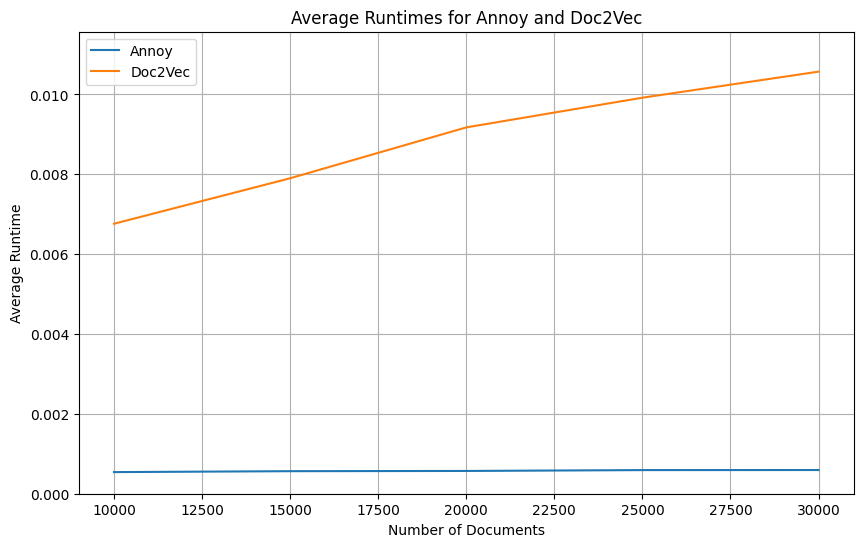

In [28]:
## Plot average runtimes
import matplotlib.pyplot as plt

x_values = [item[1] for item in runtimes_annoy]
y_values_approach1 = [item[0] for item in runtimes_annoy]
y_values_approach2 = [item[0] for item in runtimes_default]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values_approach1, label='Annoy')
plt.plot(x_values, y_values_approach2, label='Doc2Vec')


# Adding labels and title
plt.xlabel('Number of Documents')
plt.ylabel('Average Runtime')
plt.title('Average Runtimes for Annoy and Doc2Vec')
plt.legend()
plt.grid(True)

plt.ylim(bottom=0, top=max(max(y_values_approach1), max(y_values_approach2)) + 0.001)

# Display the plot
plt.show()


## Task 3: State-Of-The-Art Models

In this week's paper you will learn about [Attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) and later about the [Transformer Architecture](https://jalammar.github.io/illustrated-transformer/). At this stage, it is not required to understand the transformer architecture, but for comparison’s sake we want to include it in this week's assignment. 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Model and Encode the Articles</b> 
</div>

We will use the [sentence-transformers](https://www.sbert.net/index.html) package to encode news articles. A sentence-transformer can be seen as a modification of the transformer architecture and allows us to encode documents (i.e. news articles). 

Please implement the following steps:

 1. Load the pretrained model [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) using the [sentence-transformers](https://www.sbert.net/index.html) package. You may need to install the package with the provided terminal command.
 2. Encode all articles in the dataset. You want to enable GPU acceleration for this. This should take you <1 min with GPU.

In [29]:
!pip install -q sentence_transformers --disable-pip-version-check --root-user-action=ignore 

In [30]:
from sentence_transformers import SentenceTransformer

In [31]:
# Load the transformer-based model
model_name = "all-mpnet-base-v2"
model_trans = SentenceTransformer(model_name)

texts = test_sample["text"].tolist()

# Encode all articles 
article_embeddings = model_trans.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

 <div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Implement Vector Search</b> 
</div>
 
To avoid linear search through all embeddings and long runtimes, use the Annoy (Approximate Nearest Neighbors Oh Yeah) package implementing an approximate k-nearest neighbor algorithm built upon an index tree (https://github.com/spotify/annoy).
 
 1. Use [Annoy](https://github.com/spotify/annoy) to index the articles. Building the index on all articles takes about 5 minutes.
 2. Write a function **searchWithTransformer(mode, query, N, stopwordflag)** with similar functionality to the previous implemented functions. Internally, the function should encode a query and use the document index to find similar documents.
 3. To test your implementation, use one entire article as query.

In [32]:
# Use annoy to build the document index 
from annoy import AnnoyIndex
index_dimension = model_trans.get_sentence_embedding_dimension()
annoy_index = AnnoyIndex(index_dimension, 'angular')
for i in range(len(article_embeddings)):
    annoy_index.add_item(i, article_embeddings[i])
annoy_index.build(n_trees=10)

True

In [33]:
# Implement function searchWithContextualEmbedding(query, N, stopwordflag) 

def searchWithTransformer(model, query, N, stopwordflag, q_index):
    global index_trans
    # Encode the query using the provided transformer model
    query_embedding = model.encode([query])[0]

    # Get the N most similar documents using the Annoy index
    similar_indices = annoy_index.get_nns_by_vector(query_embedding, N, search_k=-1, include_distances=False)

    # Retrieve the corresponding news articles
    similar_articles = [test_sample.iloc[i]['text'] for i in similar_indices]
    index_trans = np.argmax(similar_indices == q_index)
    return similar_articles

In [34]:
# Test your search implementation
# Define query
query_article_index = 0  # Replace with the index of the article you want to use as a query
query_article = test_sample.iloc[query_article_index]['text']
N = 5  # Number of most related news articles to retrieve
stopwordflag = True  # Toggle stopword removal
result_articles_transformer = searchWithTransformer(model_trans, query_article, N, stopwordflag, query_article_index)

# Search for similar articles
print(f"Query Article:\n{query_article}\n")
print(f"Top {N} Most Related Articles using Annoy:")
for i, article in enumerate(result_articles_transformer, start=1):
    print(f"{i}. {article}\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query Article:
a prison chaplain who admitted to sexually assaulting three inmates may only spend a year behind bars. why don't we seem to care?

 

when leticia villarreal, 42, began her prison sentence at mcpherson unit, a women’s facility in arkansas, she throbbed with anger and pain. she was an undocumented immigrant from mexico. she didn’t speak english. no one visited, no one called. she deeply missed her children. she was, for the first time in her life, utterly alone.
and then, she found god.
kenneth dewitt, a charismatic prison chaplain, welcomed her into the principles and applications for life, or pal, program ― a religious initiative for inmates that’s based on the teachings of disgraced evangelical fundamentalist bill gothard.
women in the pal program lived in a separate barracks and dedicated much of their days to study and prayer. it was quieter and cleaner than living with the general population, villarreal said, an overall improvement in quality of life. and it was rum

## Task 4: Comparison

Now that we implemented a simple search engine based on three different models, we want to compare them. As a test scenario, we simulate a news article search, where users can enter a short query and our service returns relevant news articles. To measure how well our three models would perform in such a scenario, we will use the article titles to simulate search queries. The objective for a real search engine would be to present a list of related news articles to the user, with the one corresponding to the title as one of the first search results (typically called the "10 blue links" in search engine development for obvious reasons).

Please implement the following steps:

1. Use the article titles in the test set as queries. Make use of the functions you implemented before to determine at what position the given model ranks the corresponding article among all articles in the test set (i.e. set N to the number of articles in the dataset). Do this for the Doc2Vec, TF-IDF and Transformer model. Experiment with removing stopwords.
2. Calculate the average position for each model over all articles you sampled. A perfect model would always return the corresponding article ID at position 0.
3. Visualize the results as a cumulative recall curve with the list position on the x-axis and the percentage of items that appear at that position or less on the y-axis. The resulting curve is monotonically increasing.
4. Interpret the results. Which model yields the best results?

In [35]:
N = 500
model_names = ['Doc2Vec', 'TF-IDF', 'Transformer']

In [36]:
# Use searchWithEmbedding() with article titles as query
# Use searchWithTransformer() with article titles as query
# Use searchWithTFIDF() with article titles as query
d2v = []
tfi = []
tr = []
for i in tqdm(range(N), desc="Calculating Rankings"):
    stopwordflag = True
    article_title = test_sample.iloc[i]['title']
    title_index = i
    # Perform searches using different models
    doc2vec_results = searchWithEmbedding(test_sample['embeddings'], model_doc2vec, article_title, N, stopwordflag, title_index)
    d2v.append(index_d2v)
    tfidf_results = searchWithTFIDF(tfidf_matrix, vectorizer, article_title, N, stopwordflag, title_index)
    tfi.append(index_tfi)
    transformer_results = searchWithTransformer(model_trans, article_title, N, stopwordflag, title_index)
    tr.append(index_trans)

Calculating Rankings:   0%|          | 0/500 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   0%|          | 1/500 [00:00<02:21,  3.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   0%|          | 2/500 [00:00<02:15,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   1%|          | 3/500 [00:00<02:15,  3.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   1%|          | 4/500 [00:01<02:13,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   1%|          | 5/500 [00:01<02:12,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   1%|          | 6/500 [00:01<02:10,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   1%|▏         | 7/500 [00:01<02:09,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   2%|▏         | 8/500 [00:02<02:09,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   2%|▏         | 9/500 [00:02<02:09,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   2%|▏         | 10/500 [00:02<02:12,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   2%|▏         | 11/500 [00:02<02:12,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   2%|▏         | 12/500 [00:03<02:14,  3.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   3%|▎         | 13/500 [00:03<02:17,  3.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   3%|▎         | 14/500 [00:03<02:18,  3.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   3%|▎         | 15/500 [00:04<02:16,  3.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   3%|▎         | 16/500 [00:04<02:13,  3.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   3%|▎         | 17/500 [00:04<02:10,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   4%|▎         | 18/500 [00:04<02:09,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   4%|▍         | 19/500 [00:05<02:07,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   4%|▍         | 20/500 [00:05<02:06,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   4%|▍         | 21/500 [00:05<02:05,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   4%|▍         | 22/500 [00:05<02:03,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   5%|▍         | 23/500 [00:06<02:03,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   5%|▍         | 24/500 [00:06<02:06,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   5%|▌         | 25/500 [00:06<02:09,  3.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   5%|▌         | 26/500 [00:07<02:07,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   5%|▌         | 27/500 [00:07<02:06,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   6%|▌         | 28/500 [00:07<02:04,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   6%|▌         | 29/500 [00:07<02:04,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   6%|▌         | 30/500 [00:08<02:03,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   6%|▌         | 31/500 [00:08<02:03,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   6%|▋         | 32/500 [00:08<02:03,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   7%|▋         | 33/500 [00:08<02:02,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   7%|▋         | 34/500 [00:09<02:02,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   7%|▋         | 35/500 [00:09<02:02,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   7%|▋         | 36/500 [00:09<02:01,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   7%|▋         | 37/500 [00:09<02:01,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   8%|▊         | 38/500 [00:10<02:00,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   8%|▊         | 39/500 [00:10<01:59,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   8%|▊         | 40/500 [00:10<02:00,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   8%|▊         | 41/500 [00:10<01:59,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   8%|▊         | 42/500 [00:11<02:00,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   9%|▊         | 43/500 [00:11<01:58,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   9%|▉         | 44/500 [00:11<01:58,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   9%|▉         | 45/500 [00:11<01:58,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   9%|▉         | 46/500 [00:12<01:58,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:   9%|▉         | 47/500 [00:12<01:58,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  10%|▉         | 48/500 [00:12<01:58,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  10%|▉         | 49/500 [00:13<01:58,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  10%|█         | 50/500 [00:13<01:57,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  10%|█         | 51/500 [00:13<01:57,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  10%|█         | 52/500 [00:13<01:56,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  11%|█         | 53/500 [00:14<01:56,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  11%|█         | 54/500 [00:14<01:56,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  11%|█         | 55/500 [00:14<01:55,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  11%|█         | 56/500 [00:14<01:54,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  11%|█▏        | 57/500 [00:15<01:55,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  12%|█▏        | 58/500 [00:15<01:55,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  12%|█▏        | 59/500 [00:15<01:56,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  12%|█▏        | 60/500 [00:15<01:55,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  12%|█▏        | 61/500 [00:16<01:55,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  12%|█▏        | 62/500 [00:16<01:55,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  13%|█▎        | 63/500 [00:16<01:57,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  13%|█▎        | 64/500 [00:16<01:56,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  13%|█▎        | 65/500 [00:17<01:55,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  13%|█▎        | 66/500 [00:17<01:53,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  13%|█▎        | 67/500 [00:17<01:52,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  14%|█▎        | 68/500 [00:18<01:52,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  14%|█▍        | 69/500 [00:18<01:52,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  14%|█▍        | 70/500 [00:18<01:52,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  14%|█▍        | 71/500 [00:18<01:52,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  14%|█▍        | 72/500 [00:19<01:52,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  15%|█▍        | 73/500 [00:19<01:52,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  15%|█▍        | 74/500 [00:19<01:51,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  15%|█▌        | 75/500 [00:19<01:50,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  15%|█▌        | 76/500 [00:20<01:50,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  15%|█▌        | 77/500 [00:20<01:52,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  16%|█▌        | 78/500 [00:20<01:51,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  16%|█▌        | 79/500 [00:20<01:49,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  16%|█▌        | 80/500 [00:21<01:48,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  16%|█▌        | 81/500 [00:21<01:48,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  16%|█▋        | 82/500 [00:21<01:47,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  17%|█▋        | 83/500 [00:21<01:47,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  17%|█▋        | 84/500 [00:22<01:46,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  17%|█▋        | 85/500 [00:22<01:47,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  17%|█▋        | 86/500 [00:22<01:47,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  17%|█▋        | 87/500 [00:22<01:47,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  18%|█▊        | 88/500 [00:23<01:47,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  18%|█▊        | 89/500 [00:23<01:47,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  18%|█▊        | 90/500 [00:23<01:46,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  18%|█▊        | 91/500 [00:23<01:46,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  18%|█▊        | 92/500 [00:24<01:45,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  19%|█▊        | 93/500 [00:24<01:45,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  19%|█▉        | 94/500 [00:24<01:44,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  19%|█▉        | 95/500 [00:25<01:44,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  19%|█▉        | 96/500 [00:25<01:44,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  19%|█▉        | 97/500 [00:25<01:44,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  20%|█▉        | 98/500 [00:25<01:43,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  20%|█▉        | 99/500 [00:26<01:43,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  20%|██        | 100/500 [00:26<01:43,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  20%|██        | 101/500 [00:26<01:43,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  20%|██        | 102/500 [00:26<01:44,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  21%|██        | 103/500 [00:27<01:44,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  21%|██        | 104/500 [00:27<01:43,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  21%|██        | 105/500 [00:27<01:42,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  21%|██        | 106/500 [00:27<01:41,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  21%|██▏       | 107/500 [00:28<01:40,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  22%|██▏       | 108/500 [00:28<01:40,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  22%|██▏       | 109/500 [00:28<01:41,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  22%|██▏       | 110/500 [00:28<01:41,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  22%|██▏       | 111/500 [00:29<01:40,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  22%|██▏       | 112/500 [00:29<01:40,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  23%|██▎       | 113/500 [00:29<01:40,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  23%|██▎       | 114/500 [00:29<01:40,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  23%|██▎       | 115/500 [00:30<01:43,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  23%|██▎       | 116/500 [00:30<01:43,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  23%|██▎       | 117/500 [00:30<01:43,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  24%|██▎       | 118/500 [00:31<01:42,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  24%|██▍       | 119/500 [00:31<01:40,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  24%|██▍       | 120/500 [00:31<01:39,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  24%|██▍       | 121/500 [00:31<01:38,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  24%|██▍       | 122/500 [00:32<01:37,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  25%|██▍       | 123/500 [00:32<01:37,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  25%|██▍       | 124/500 [00:32<01:36,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  25%|██▌       | 125/500 [00:32<01:35,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  25%|██▌       | 126/500 [00:33<01:35,  3.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  25%|██▌       | 127/500 [00:33<01:35,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  26%|██▌       | 128/500 [00:33<01:34,  3.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  26%|██▌       | 129/500 [00:33<01:34,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  26%|██▌       | 130/500 [00:34<01:35,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  26%|██▌       | 131/500 [00:34<01:35,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  26%|██▋       | 132/500 [00:34<01:42,  3.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  27%|██▋       | 133/500 [00:34<01:42,  3.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  27%|██▋       | 134/500 [00:35<01:41,  3.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  27%|██▋       | 135/500 [00:35<01:39,  3.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  27%|██▋       | 136/500 [00:35<01:37,  3.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  27%|██▋       | 137/500 [00:36<01:36,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  28%|██▊       | 138/500 [00:36<01:34,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  28%|██▊       | 139/500 [00:36<01:34,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  28%|██▊       | 140/500 [00:36<01:35,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  28%|██▊       | 141/500 [00:37<01:34,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  28%|██▊       | 142/500 [00:37<01:33,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  29%|██▊       | 143/500 [00:37<01:32,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  29%|██▉       | 144/500 [00:37<01:32,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  29%|██▉       | 145/500 [00:38<01:32,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  29%|██▉       | 146/500 [00:38<01:32,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  29%|██▉       | 147/500 [00:38<01:32,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  30%|██▉       | 148/500 [00:38<01:31,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  30%|██▉       | 149/500 [00:39<01:31,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  30%|███       | 150/500 [00:39<01:30,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  30%|███       | 151/500 [00:39<01:30,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  30%|███       | 152/500 [00:39<01:30,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  31%|███       | 153/500 [00:40<01:30,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  31%|███       | 154/500 [00:40<01:29,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  31%|███       | 155/500 [00:40<01:29,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  31%|███       | 156/500 [00:40<01:29,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  31%|███▏      | 157/500 [00:41<01:28,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  32%|███▏      | 158/500 [00:41<01:29,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  32%|███▏      | 159/500 [00:41<01:29,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  32%|███▏      | 160/500 [00:42<01:28,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  32%|███▏      | 161/500 [00:42<01:28,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  32%|███▏      | 162/500 [00:42<01:28,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  33%|███▎      | 163/500 [00:42<01:27,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  33%|███▎      | 164/500 [00:43<01:26,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  33%|███▎      | 165/500 [00:43<01:26,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  33%|███▎      | 166/500 [00:43<01:26,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  33%|███▎      | 167/500 [00:43<01:26,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  34%|███▎      | 168/500 [00:44<01:26,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  34%|███▍      | 169/500 [00:44<01:25,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  34%|███▍      | 170/500 [00:44<01:24,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  34%|███▍      | 171/500 [00:44<01:24,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  34%|███▍      | 172/500 [00:45<01:25,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  35%|███▍      | 173/500 [00:45<01:25,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  35%|███▍      | 174/500 [00:45<01:24,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  35%|███▌      | 175/500 [00:45<01:24,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  35%|███▌      | 176/500 [00:46<01:25,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  35%|███▌      | 177/500 [00:46<01:24,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  36%|███▌      | 178/500 [00:46<01:25,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  36%|███▌      | 179/500 [00:46<01:25,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  36%|███▌      | 180/500 [00:47<01:24,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  36%|███▌      | 181/500 [00:47<01:24,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  36%|███▋      | 182/500 [00:47<01:22,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  37%|███▋      | 183/500 [00:48<01:22,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  37%|███▋      | 184/500 [00:48<01:22,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  37%|███▋      | 185/500 [00:48<01:22,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  37%|███▋      | 186/500 [00:48<01:21,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  37%|███▋      | 187/500 [00:49<01:21,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  38%|███▊      | 188/500 [00:49<01:22,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  38%|███▊      | 189/500 [00:49<01:22,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  38%|███▊      | 190/500 [00:49<01:22,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  38%|███▊      | 191/500 [00:50<01:21,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  38%|███▊      | 192/500 [00:50<01:21,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  39%|███▊      | 193/500 [00:50<01:21,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  39%|███▉      | 194/500 [00:50<01:20,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  39%|███▉      | 195/500 [00:51<01:19,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  39%|███▉      | 196/500 [00:51<01:19,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  39%|███▉      | 197/500 [00:51<01:18,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  40%|███▉      | 198/500 [00:51<01:17,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  40%|███▉      | 199/500 [00:52<01:17,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  40%|████      | 200/500 [00:52<01:17,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  40%|████      | 201/500 [00:52<01:17,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  40%|████      | 202/500 [00:52<01:16,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  41%|████      | 203/500 [00:53<01:17,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  41%|████      | 204/500 [00:53<01:17,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  41%|████      | 205/500 [00:53<01:16,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  41%|████      | 206/500 [00:54<01:15,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  41%|████▏     | 207/500 [00:54<01:15,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  42%|████▏     | 208/500 [00:54<01:15,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  42%|████▏     | 209/500 [00:54<01:15,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  42%|████▏     | 210/500 [00:55<01:14,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  42%|████▏     | 211/500 [00:55<01:14,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  42%|████▏     | 212/500 [00:55<01:15,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  43%|████▎     | 213/500 [00:55<01:15,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  43%|████▎     | 214/500 [00:56<01:15,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  43%|████▎     | 215/500 [00:56<01:15,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  43%|████▎     | 216/500 [00:56<01:15,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  43%|████▎     | 217/500 [00:56<01:17,  3.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  44%|████▎     | 218/500 [00:57<01:15,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  44%|████▍     | 219/500 [00:57<01:14,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  44%|████▍     | 220/500 [00:57<01:13,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  44%|████▍     | 221/500 [00:57<01:12,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  44%|████▍     | 222/500 [00:58<01:11,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  45%|████▍     | 223/500 [00:58<01:11,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  45%|████▍     | 224/500 [00:58<01:11,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  45%|████▌     | 225/500 [00:58<01:11,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  45%|████▌     | 226/500 [00:59<01:11,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  45%|████▌     | 227/500 [00:59<01:11,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  46%|████▌     | 228/500 [00:59<01:10,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  46%|████▌     | 229/500 [01:00<01:10,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  46%|████▌     | 230/500 [01:00<01:11,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  46%|████▌     | 231/500 [01:00<01:11,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  46%|████▋     | 232/500 [01:00<01:12,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  47%|████▋     | 233/500 [01:01<01:12,  3.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  47%|████▋     | 234/500 [01:01<01:11,  3.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  47%|████▋     | 235/500 [01:01<01:10,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  47%|████▋     | 236/500 [01:01<01:10,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  47%|████▋     | 237/500 [01:02<01:10,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  48%|████▊     | 238/500 [01:02<01:09,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  48%|████▊     | 239/500 [01:02<01:08,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  48%|████▊     | 240/500 [01:02<01:07,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  48%|████▊     | 241/500 [01:03<01:07,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  48%|████▊     | 242/500 [01:03<01:07,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  49%|████▊     | 243/500 [01:03<01:06,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  49%|████▉     | 244/500 [01:03<01:06,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  49%|████▉     | 245/500 [01:04<01:06,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  49%|████▉     | 246/500 [01:04<01:05,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  49%|████▉     | 247/500 [01:04<01:04,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  50%|████▉     | 248/500 [01:05<01:04,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  50%|████▉     | 249/500 [01:05<01:04,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  50%|█████     | 250/500 [01:05<01:04,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  50%|█████     | 251/500 [01:05<01:04,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  50%|█████     | 252/500 [01:06<01:03,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  51%|█████     | 253/500 [01:06<01:05,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  51%|█████     | 254/500 [01:06<01:06,  3.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  51%|█████     | 255/500 [01:06<01:07,  3.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  51%|█████     | 256/500 [01:07<01:05,  3.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  51%|█████▏    | 257/500 [01:07<01:04,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  52%|█████▏    | 258/500 [01:07<01:04,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  52%|█████▏    | 259/500 [01:07<01:03,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  52%|█████▏    | 260/500 [01:08<01:02,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  52%|█████▏    | 261/500 [01:08<01:02,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  52%|█████▏    | 262/500 [01:08<01:02,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  53%|█████▎    | 263/500 [01:08<01:01,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  53%|█████▎    | 264/500 [01:09<01:01,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  53%|█████▎    | 265/500 [01:09<01:01,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  53%|█████▎    | 266/500 [01:09<01:00,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  53%|█████▎    | 267/500 [01:10<00:59,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  54%|█████▎    | 268/500 [01:10<00:59,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  54%|█████▍    | 269/500 [01:10<00:59,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  54%|█████▍    | 270/500 [01:10<00:59,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  54%|█████▍    | 271/500 [01:11<00:59,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  54%|█████▍    | 272/500 [01:11<00:59,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  55%|█████▍    | 273/500 [01:11<00:58,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  55%|█████▍    | 274/500 [01:11<00:58,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  55%|█████▌    | 275/500 [01:12<00:58,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  55%|█████▌    | 276/500 [01:12<00:58,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  55%|█████▌    | 277/500 [01:12<00:57,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  56%|█████▌    | 278/500 [01:12<00:58,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  56%|█████▌    | 279/500 [01:13<00:57,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  56%|█████▌    | 280/500 [01:13<00:56,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  56%|█████▌    | 281/500 [01:13<00:56,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  56%|█████▋    | 282/500 [01:13<00:56,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  57%|█████▋    | 283/500 [01:14<00:56,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  57%|█████▋    | 284/500 [01:14<00:56,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  57%|█████▋    | 285/500 [01:14<00:55,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  57%|█████▋    | 286/500 [01:14<00:56,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  57%|█████▋    | 287/500 [01:15<00:56,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  58%|█████▊    | 288/500 [01:15<00:56,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  58%|█████▊    | 289/500 [01:15<00:55,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  58%|█████▊    | 290/500 [01:16<00:55,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  58%|█████▊    | 291/500 [01:16<00:55,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  58%|█████▊    | 292/500 [01:16<00:55,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  59%|█████▊    | 293/500 [01:16<00:55,  3.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  59%|█████▉    | 294/500 [01:17<00:55,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  59%|█████▉    | 295/500 [01:17<00:54,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  59%|█████▉    | 296/500 [01:17<00:53,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  59%|█████▉    | 297/500 [01:17<00:53,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  60%|█████▉    | 298/500 [01:18<00:52,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  60%|█████▉    | 299/500 [01:18<00:52,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  60%|██████    | 300/500 [01:18<00:52,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  60%|██████    | 301/500 [01:18<00:52,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  60%|██████    | 302/500 [01:19<00:52,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  61%|██████    | 303/500 [01:19<00:51,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  61%|██████    | 304/500 [01:19<00:50,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  61%|██████    | 305/500 [01:19<00:50,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  61%|██████    | 306/500 [01:20<00:50,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  61%|██████▏   | 307/500 [01:20<00:50,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  62%|██████▏   | 308/500 [01:20<00:50,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  62%|██████▏   | 309/500 [01:20<00:49,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  62%|██████▏   | 310/500 [01:21<00:49,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  62%|██████▏   | 311/500 [01:21<00:48,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  62%|██████▏   | 312/500 [01:21<00:47,  3.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  63%|██████▎   | 313/500 [01:22<00:48,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  63%|██████▎   | 314/500 [01:22<00:47,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  63%|██████▎   | 315/500 [01:22<00:47,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  63%|██████▎   | 316/500 [01:22<00:47,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  63%|██████▎   | 317/500 [01:23<00:47,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  64%|██████▎   | 318/500 [01:23<00:47,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  64%|██████▍   | 319/500 [01:23<00:46,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  64%|██████▍   | 320/500 [01:23<00:46,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  64%|██████▍   | 321/500 [01:24<00:46,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  64%|██████▍   | 322/500 [01:24<00:46,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  65%|██████▍   | 323/500 [01:24<00:46,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  65%|██████▍   | 324/500 [01:24<00:45,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  65%|██████▌   | 325/500 [01:25<00:45,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  65%|██████▌   | 326/500 [01:25<00:45,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  65%|██████▌   | 327/500 [01:25<00:44,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  66%|██████▌   | 328/500 [01:25<00:44,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  66%|██████▌   | 329/500 [01:26<00:45,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  66%|██████▌   | 330/500 [01:26<00:44,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  66%|██████▌   | 331/500 [01:26<00:45,  3.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  66%|██████▋   | 332/500 [01:26<00:44,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  67%|██████▋   | 333/500 [01:27<00:44,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  67%|██████▋   | 334/500 [01:27<00:43,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  67%|██████▋   | 335/500 [01:27<00:42,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  67%|██████▋   | 336/500 [01:28<00:42,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  67%|██████▋   | 337/500 [01:28<00:42,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  68%|██████▊   | 338/500 [01:28<00:41,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  68%|██████▊   | 339/500 [01:28<00:41,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  68%|██████▊   | 340/500 [01:29<00:41,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  68%|██████▊   | 341/500 [01:29<00:41,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  68%|██████▊   | 342/500 [01:29<00:41,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  69%|██████▊   | 343/500 [01:29<00:41,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  69%|██████▉   | 344/500 [01:30<00:41,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  69%|██████▉   | 345/500 [01:30<00:41,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  69%|██████▉   | 346/500 [01:30<00:40,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  69%|██████▉   | 347/500 [01:30<00:40,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  70%|██████▉   | 348/500 [01:31<00:39,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  70%|██████▉   | 349/500 [01:31<00:40,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  70%|███████   | 350/500 [01:31<00:40,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  70%|███████   | 351/500 [01:31<00:39,  3.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  70%|███████   | 352/500 [01:32<00:39,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  71%|███████   | 353/500 [01:32<00:39,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  71%|███████   | 354/500 [01:32<00:38,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  71%|███████   | 355/500 [01:33<00:38,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  71%|███████   | 356/500 [01:33<00:37,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  71%|███████▏  | 357/500 [01:33<00:37,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  72%|███████▏  | 358/500 [01:33<00:36,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  72%|███████▏  | 359/500 [01:34<00:36,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  72%|███████▏  | 360/500 [01:34<00:36,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  72%|███████▏  | 361/500 [01:34<00:35,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  72%|███████▏  | 362/500 [01:34<00:35,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  73%|███████▎  | 363/500 [01:35<00:35,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  73%|███████▎  | 364/500 [01:35<00:35,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  73%|███████▎  | 365/500 [01:35<00:34,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  73%|███████▎  | 366/500 [01:35<00:34,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  73%|███████▎  | 367/500 [01:36<00:34,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  74%|███████▎  | 368/500 [01:36<00:34,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  74%|███████▍  | 369/500 [01:36<00:34,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  74%|███████▍  | 370/500 [01:36<00:34,  3.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  74%|███████▍  | 371/500 [01:37<00:34,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  74%|███████▍  | 372/500 [01:37<00:33,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  75%|███████▍  | 373/500 [01:37<00:33,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  75%|███████▍  | 374/500 [01:37<00:32,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  75%|███████▌  | 375/500 [01:38<00:32,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  75%|███████▌  | 376/500 [01:38<00:32,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  75%|███████▌  | 377/500 [01:38<00:32,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  76%|███████▌  | 378/500 [01:39<00:31,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  76%|███████▌  | 379/500 [01:39<00:31,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  76%|███████▌  | 380/500 [01:39<00:30,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  76%|███████▌  | 381/500 [01:39<00:30,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  76%|███████▋  | 382/500 [01:40<00:30,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  77%|███████▋  | 383/500 [01:40<00:30,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  77%|███████▋  | 384/500 [01:40<00:29,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  77%|███████▋  | 385/500 [01:40<00:29,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  77%|███████▋  | 386/500 [01:41<00:29,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  77%|███████▋  | 387/500 [01:41<00:29,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  78%|███████▊  | 388/500 [01:41<00:29,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  78%|███████▊  | 389/500 [01:41<00:28,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  78%|███████▊  | 390/500 [01:42<00:28,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  78%|███████▊  | 391/500 [01:42<00:28,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  78%|███████▊  | 392/500 [01:42<00:28,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  79%|███████▊  | 393/500 [01:42<00:27,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  79%|███████▉  | 394/500 [01:43<00:27,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  79%|███████▉  | 395/500 [01:43<00:27,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  79%|███████▉  | 396/500 [01:43<00:27,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  79%|███████▉  | 397/500 [01:43<00:27,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  80%|███████▉  | 398/500 [01:44<00:26,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  80%|███████▉  | 399/500 [01:44<00:26,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  80%|████████  | 400/500 [01:44<00:26,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  80%|████████  | 401/500 [01:45<00:26,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  80%|████████  | 402/500 [01:45<00:25,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  81%|████████  | 403/500 [01:45<00:25,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  81%|████████  | 404/500 [01:45<00:25,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  81%|████████  | 405/500 [01:46<00:24,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  81%|████████  | 406/500 [01:46<00:24,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  81%|████████▏ | 407/500 [01:46<00:24,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  82%|████████▏ | 408/500 [01:46<00:24,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  82%|████████▏ | 409/500 [01:47<00:23,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  82%|████████▏ | 410/500 [01:47<00:23,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  82%|████████▏ | 411/500 [01:47<00:23,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  82%|████████▏ | 412/500 [01:47<00:23,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  83%|████████▎ | 413/500 [01:48<00:22,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  83%|████████▎ | 414/500 [01:48<00:22,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  83%|████████▎ | 415/500 [01:48<00:22,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  83%|████████▎ | 416/500 [01:48<00:21,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  83%|████████▎ | 417/500 [01:49<00:21,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  84%|████████▎ | 418/500 [01:49<00:21,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  84%|████████▍ | 419/500 [01:49<00:21,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  84%|████████▍ | 420/500 [01:49<00:20,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  84%|████████▍ | 421/500 [01:50<00:20,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  84%|████████▍ | 422/500 [01:50<00:20,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  85%|████████▍ | 423/500 [01:50<00:20,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  85%|████████▍ | 424/500 [01:51<00:19,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  85%|████████▌ | 425/500 [01:51<00:19,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  85%|████████▌ | 426/500 [01:51<00:19,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  85%|████████▌ | 427/500 [01:51<00:19,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  86%|████████▌ | 428/500 [01:52<00:18,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  86%|████████▌ | 429/500 [01:52<00:18,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  86%|████████▌ | 430/500 [01:52<00:18,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  86%|████████▌ | 431/500 [01:52<00:17,  3.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  86%|████████▋ | 432/500 [01:53<00:17,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  87%|████████▋ | 433/500 [01:53<00:17,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  87%|████████▋ | 434/500 [01:53<00:16,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  87%|████████▋ | 435/500 [01:53<00:16,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  87%|████████▋ | 436/500 [01:54<00:16,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  87%|████████▋ | 437/500 [01:54<00:16,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  88%|████████▊ | 438/500 [01:54<00:15,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  88%|████████▊ | 439/500 [01:54<00:15,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  88%|████████▊ | 440/500 [01:55<00:15,  3.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  88%|████████▊ | 441/500 [01:55<00:15,  3.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  88%|████████▊ | 442/500 [01:55<00:14,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  89%|████████▊ | 443/500 [01:55<00:14,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  89%|████████▉ | 444/500 [01:56<00:14,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  89%|████████▉ | 445/500 [01:56<00:14,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  89%|████████▉ | 446/500 [01:56<00:14,  3.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  89%|████████▉ | 447/500 [01:56<00:13,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  90%|████████▉ | 448/500 [01:57<00:13,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  90%|████████▉ | 449/500 [01:57<00:13,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  90%|█████████ | 450/500 [01:57<00:12,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  90%|█████████ | 451/500 [01:57<00:12,  3.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  90%|█████████ | 452/500 [01:58<00:12,  3.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  91%|█████████ | 453/500 [01:58<00:11,  3.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  91%|█████████ | 454/500 [01:58<00:11,  3.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  91%|█████████ | 455/500 [01:59<00:11,  3.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  91%|█████████ | 456/500 [01:59<00:11,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  91%|█████████▏| 457/500 [01:59<00:11,  3.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  92%|█████████▏| 458/500 [01:59<00:10,  3.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  92%|█████████▏| 459/500 [02:00<00:10,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  92%|█████████▏| 460/500 [02:00<00:10,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  92%|█████████▏| 461/500 [02:00<00:10,  3.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  92%|█████████▏| 462/500 [02:00<00:10,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  93%|█████████▎| 463/500 [02:01<00:09,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  93%|█████████▎| 464/500 [02:01<00:09,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  93%|█████████▎| 465/500 [02:01<00:09,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  93%|█████████▎| 466/500 [02:01<00:08,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  93%|█████████▎| 467/500 [02:02<00:08,  3.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  94%|█████████▎| 468/500 [02:02<00:08,  3.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  94%|█████████▍| 469/500 [02:02<00:08,  3.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  94%|█████████▍| 470/500 [02:03<00:08,  3.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  94%|█████████▍| 471/500 [02:03<00:07,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  94%|█████████▍| 472/500 [02:03<00:07,  3.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  95%|█████████▍| 473/500 [02:03<00:07,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  95%|█████████▍| 474/500 [02:04<00:06,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  95%|█████████▌| 475/500 [02:04<00:06,  3.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  95%|█████████▌| 476/500 [02:04<00:06,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  95%|█████████▌| 477/500 [02:04<00:05,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  96%|█████████▌| 478/500 [02:05<00:05,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  96%|█████████▌| 479/500 [02:05<00:05,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  96%|█████████▌| 480/500 [02:05<00:05,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  96%|█████████▌| 481/500 [02:05<00:05,  3.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  96%|█████████▋| 482/500 [02:06<00:04,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  97%|█████████▋| 483/500 [02:06<00:04,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  97%|█████████▋| 484/500 [02:06<00:04,  3.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  97%|█████████▋| 485/500 [02:06<00:04,  3.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  97%|█████████▋| 486/500 [02:07<00:03,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  97%|█████████▋| 487/500 [02:07<00:03,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  98%|█████████▊| 488/500 [02:07<00:03,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  98%|█████████▊| 489/500 [02:07<00:02,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  98%|█████████▊| 490/500 [02:08<00:02,  3.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  98%|█████████▊| 491/500 [02:08<00:02,  3.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  98%|█████████▊| 492/500 [02:08<00:02,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  99%|█████████▊| 493/500 [02:09<00:01,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  99%|█████████▉| 494/500 [02:09<00:01,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  99%|█████████▉| 495/500 [02:09<00:01,  3.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  99%|█████████▉| 496/500 [02:09<00:01,  3.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings:  99%|█████████▉| 497/500 [02:10<00:00,  3.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings: 100%|█████████▉| 498/500 [02:10<00:00,  3.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings: 100%|█████████▉| 499/500 [02:10<00:00,  3.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating Rankings: 100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


In [37]:
# Calculate average search rank (lower is better)
def Average(lst): 
    return sum(lst) / len(lst)

d2v_avg = Average(d2v)
tfi_avg = Average(tfi)
tr_avg = Average(tr)

print(f"Average ranking for the Doc2Vec Model is: {d2v_avg}")
print(f"Average ranking for the TFIDF Model is: {tfi_avg}")
print(f"Average ranking for the Transformer Model is: {tr_avg}")

Average ranking for the Doc2Vec Model is: 153.652
Average ranking for the TFIDF Model is: 5.33
Average ranking for the Transformer Model is: 0.0


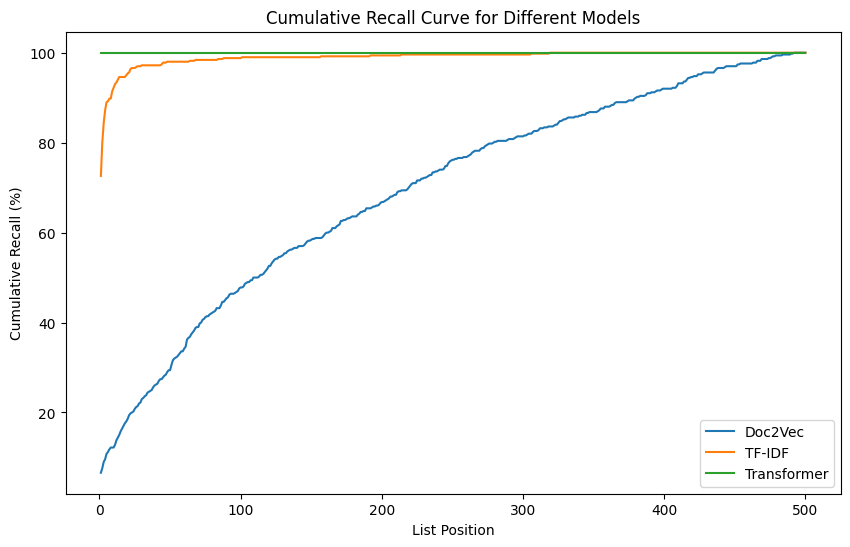

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative recall for each model
cumulative_recall_d2v = [sum(1 for r in d2v if r <= x) / N * 100 for x in range(1, N + 1)]
cumulative_recall_tfi = [sum(1 for r in tfi if r <= x) / N * 100 for x in range(1, N + 1)]
cumulative_recall_tr = [sum(1 for r in tr if r <= x) / N * 100 for x in range(1, N + 1)]

plt.figure(figsize=(10, 6))

plt.plot(range(1, N + 1), cumulative_recall_d2v, label='Doc2Vec')
plt.plot(range(1, N + 1), cumulative_recall_tfi, label='TF-IDF')
plt.plot(range(1, N + 1), cumulative_recall_tr, label='Transformer')

plt.xlabel('List Position')
plt.ylabel('Cumulative Recall (%)')
plt.legend()
plt.title('Cumulative Recall Curve for Different Models')
plt.show()